In [38]:
# ライブラリーの読み込み
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import datasets
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from sklearn.metrics import mean_absolute_error
from statistics import mean 
from matplotlib import pyplot as plt
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

In [39]:
from statsmodels.tsa.arima.model import ARIMA

In [40]:
# データの読み込み
df = pd.read_csv('./data/power_usage_2016_to_2020.csv')

In [41]:
df

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...,...
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday


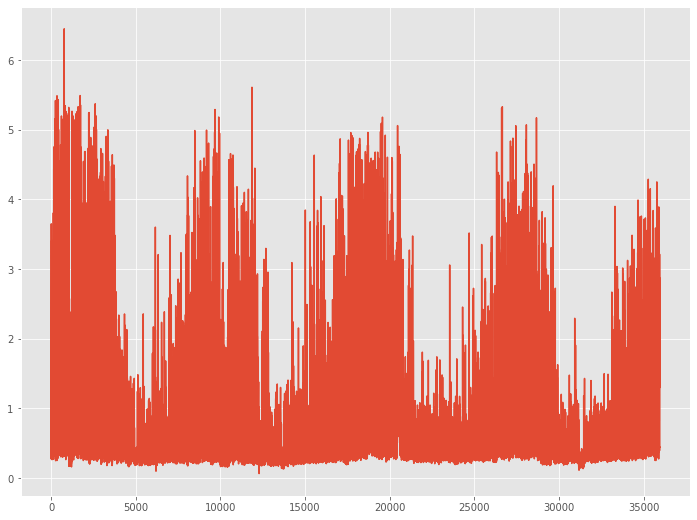

In [46]:
plt.plot(df['Value (kWh)'])

In [42]:
model = ARIMA(df['Value (kWh)'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Value (kWh)   No. Observations:                35952
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26918.906
Date:                Mon, 01 Aug 2022   AIC                          53843.813
Time:                        01:30:17   BIC                          53869.282
Sample:                             0   HQIC                         53851.915
                              - 35952                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7606      0.003    293.137      0.000       0.756       0.766
ma.L1         -0.9947      0.000  -2035.841      0.000      -0.996      -0.994
sigma2         0.2617      0.001    361.257      0.0

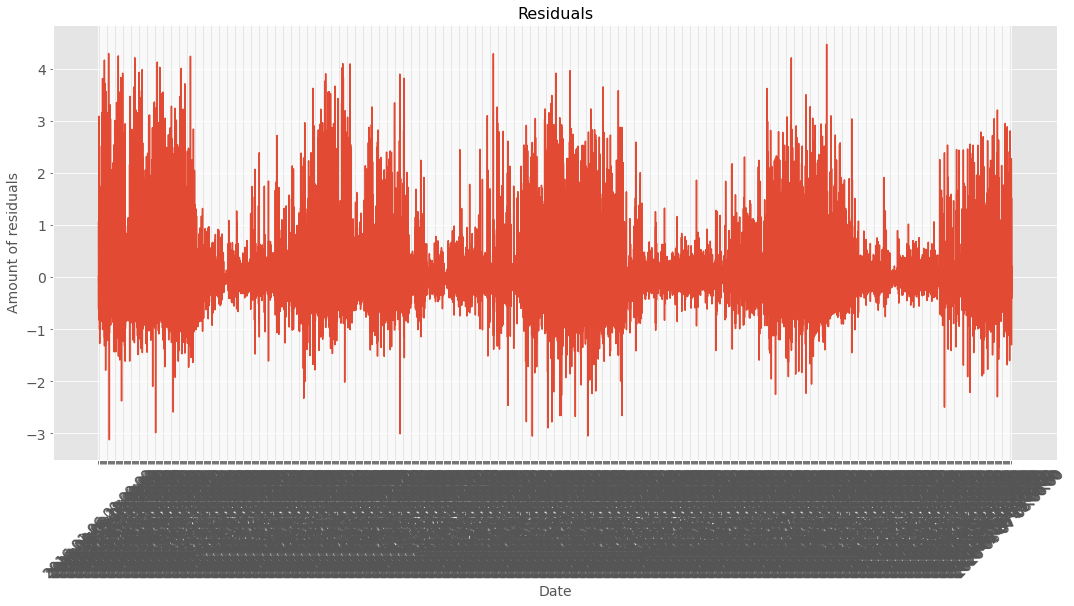

In [45]:
# Plotting residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(18, 8))
plt.plot(residuals)
plt.title('Residuals', fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Amount of residuals", fontsize=14)
plt.xticks(np.arange(0, len(df.StartDate)+1, 45), labels=[df.StartDate[i] for i in range(0, len(df.StartDate)+1, 45)], rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

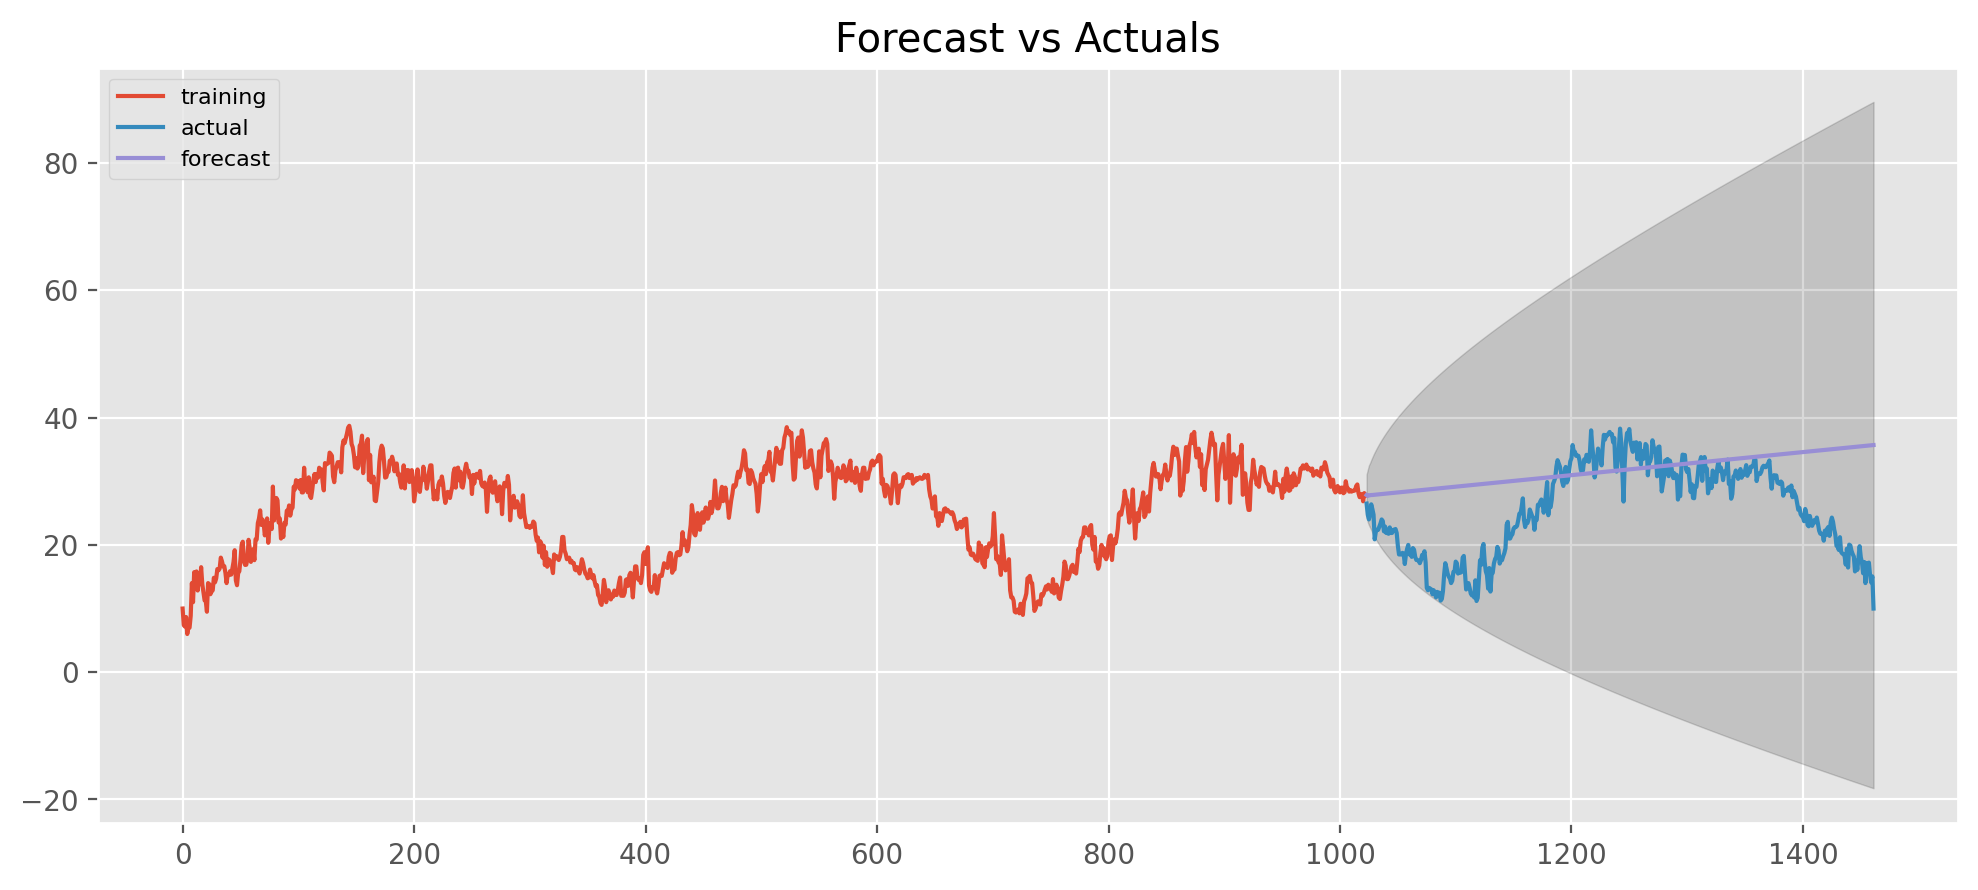

In [37]:
train = df['meantemp'][:int(np.floor((len(df)/100)*70))]
test = df['meantemp'][int(np.floor((len(df)/100)*70)):]

model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  

fc = fitted.get_forecast(len(df['meantemp'][int(np.floor((len(df)/100)*70)):]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


/home/hajime/.local/lib/python3.8/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


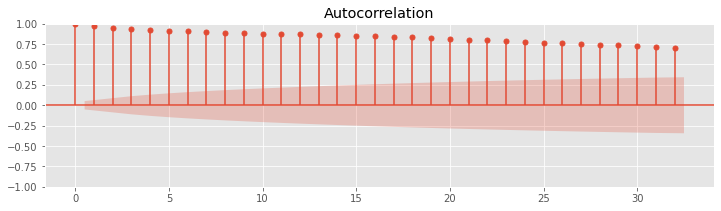

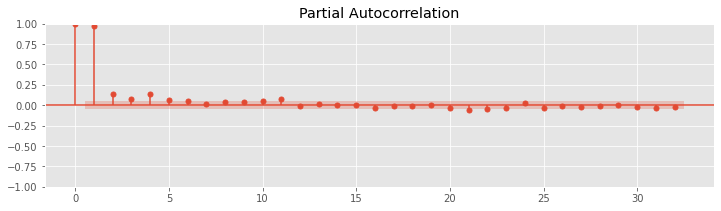

In [36]:
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 3]
# 自己相関と偏自己相関
utils.plot_acf(df.meantemp, alpha=.05)
utils.plot_pacf(df.meantemp, alpha=.05)
 

In [7]:
# 階差の次数の検討
print('d =', arima.ndiffs(data)) #d（階差）
print('D =', arima.nsdiffs(data,m=12)) #D（季節階差）


d = 1
D = 1


In [8]:
# 通常の階差処理を1回しさらに季節階差処理を1回
data_d1_d12 = pd.DataFrame(data).diff(1).diff(12).dropna()

In [9]:
data_d1_d12

,0
13,5.0
14,1.0
15,-3.0
16,-2.0
17,10.0
...,...
139,-27.0
140,-2.0
141,9.0
142,-26.0


In [17]:
# データ分割（train:学習データ、test:テストデータ）
train, test = model_selection.train_test_split(data, train_size=132)

In [18]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/home/hajime/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=911.913, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.865, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.556, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.723, Time=4.70 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=909.369, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.124, Time=0.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=911.772, Time=3.79 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.870, Time=0.22 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.478, Time=0.31 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.09 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.717, Time=0.22 sec
 ARIMA(2,0,0)(1,1,1)[12] inter

MAE:
14.898208317448123
MAPE(%):
3.0975615303185338


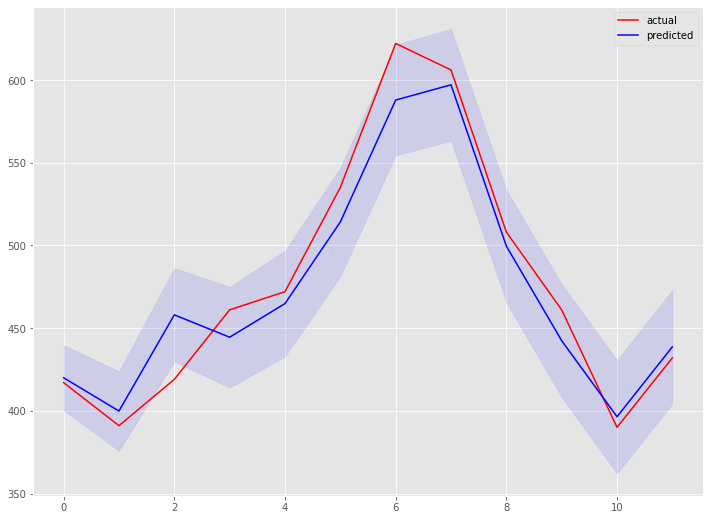

In [19]:
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 9]
# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], 
                                      return_conf_int=True)
# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(mean(abs(test - preds)/test) *100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()
 

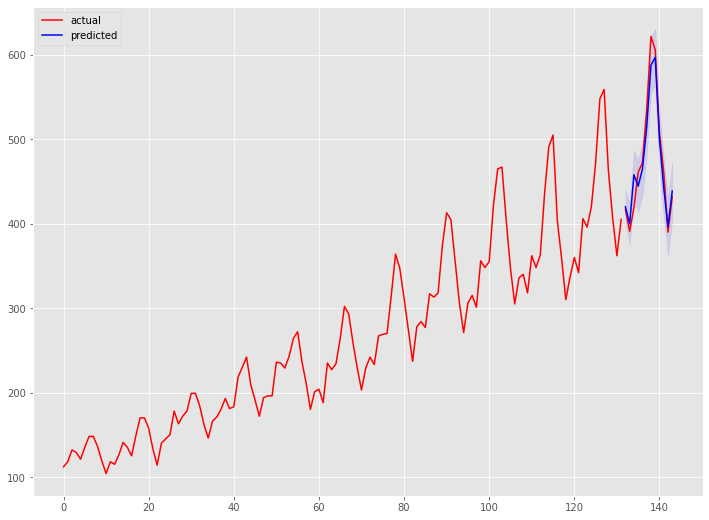

In [20]:
# グラフ（学習データとテストデータ、予測結果）
x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='r',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='r')
plt.plot(x_axis[train.shape[0]:],preds,color='b',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1,color='b')
plt.legend()
plt.show()
 

/home/hajime/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


MAE:
18.527652990128036
MAPE(%):
4.182388631290588


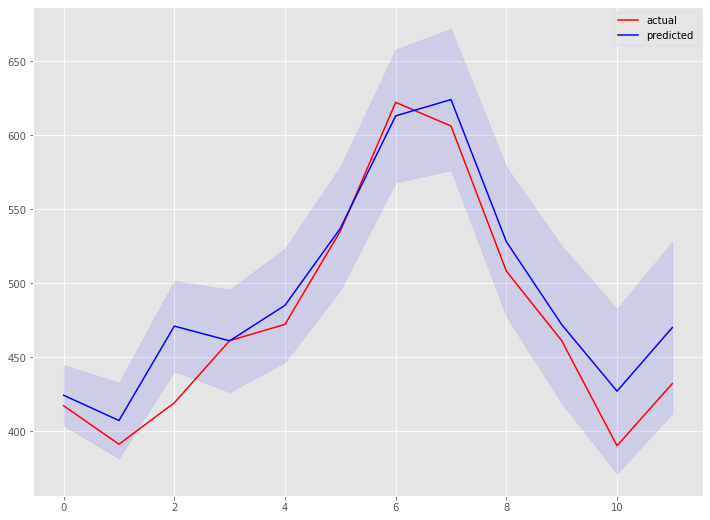

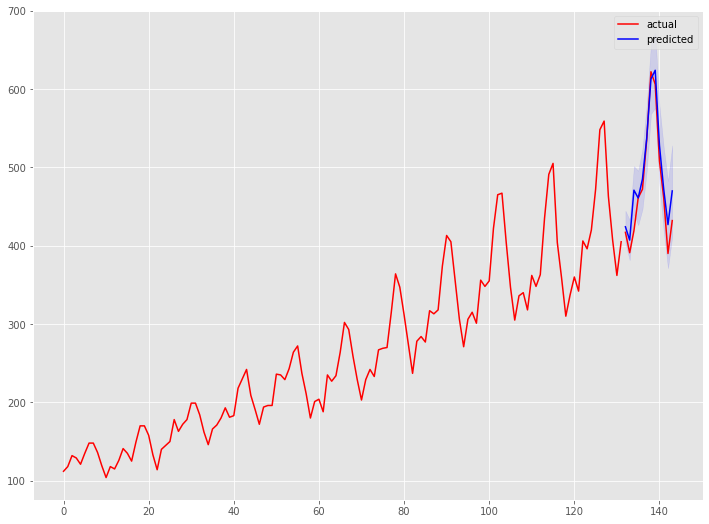

In [21]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                             seasonal=True,
                             m=12,
                             d=1,
                             D=1,
                             n_jobs=-1,
                             maxiter=10)
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 9]
# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], 
                                      return_conf_int=True)
# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(mean(abs(test - preds)/test) *100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()
# グラフ（学習データとテストデータ、予測結果）
x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='r',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='r')
plt.plot(x_axis[train.shape[0]:],preds,color='b',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1,color='b')
plt.legend()
plt.show()